In [38]:

import argparse
import os
import random
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.pyplot import imshow, imsave

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print(torchvision.__version__)

Random Seed:  999
0.2.2


In [39]:
# This cell is only for Google Colaboratory
from google.colab import drive
drive.mount('/content/gdrive')

path1 = "train_images" # Fake generated images here
path2 = "gen"   # Generator parameters path
path3 = "dis"   # Discriminator parameters path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Root directory for dataset
dataroot = "Art/Uusi_Kansio"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3 # with mnist 1, other 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
max_epoch = 100 # need more than 20 epochs for training generator

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of labels
num_labels = 10 # we will use 4, CIFAR and MNIST has 10

In [41]:
# Define which device you use for calculation. If you can use cuda, this will automatically use it. Otherwise cpu is automatically used.

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


Files already downloaded and verified


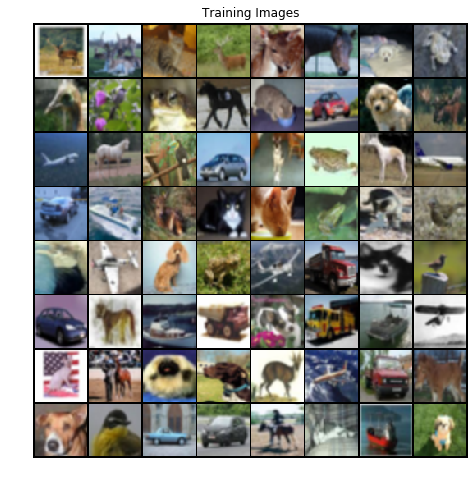

In [42]:

transform=torchvision.transforms.Compose([
                                 torchvision.transforms.Resize(image_size),
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize(
                                 (0.5,0.5,0.5), (0.5,0.5,0.5))])

dataset =  torchvision.datasets.CIFAR10('/files/', train=True, download=True, transform = transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
dataroot = []
dataset = []
# Create new dataset from images
for i in range(1,num_labels + 1):
    dataset.append(dset.ImageFolder(root=F"./Dog_images/Label{i}",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])))

# Create labels for our dataset
# Labels are in i
for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        dataset[i].samples[j] = (dataset[i].samples[j][0],i)
        
# Combine all the datasets
newdataset = torch.utils.data.ConcatDataset(dataset)

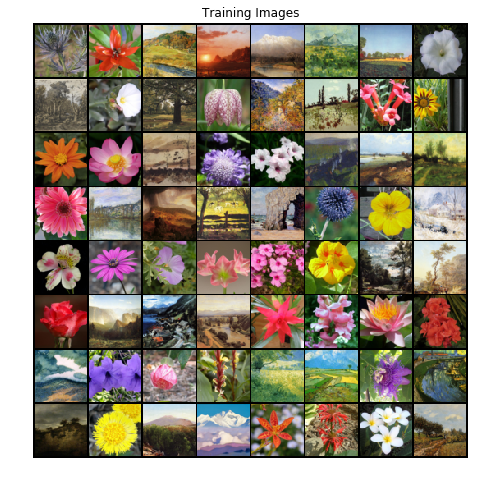

In [0]:
dataloader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
#DEVICE = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch,labels = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(DEVICE)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:

def normal_init(m, mean=0., std=0.5):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        #m.bias.data.zero_()

In [0]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, input_size=784, condition_size=10):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(nc, ndf,4,2,1,bias=False)
        
        # first parameter is number of classes, condition_size is the same as number of classes
        self.convlabel = nn.Conv2d(condition_size, ndf,4,2,1,bias=False)
        
        self.conv2 = nn.Conv2d(ndf * 2,ndf * 4, 4, 2, 1, bias = False)
        self.bn1 = nn.BatchNorm2d(ndf * 4)
        self.conv3 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 8)
        self.conv4 = nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 16)
        self.conv5 = nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False)

        self.act = nn.LeakyReLU(0.2,inplace=True)
        self.out = nn.Sigmoid()
        #self.init_weights()
        self.weight_init(mean=0.,std=0.02)
        
    def weight_init(self, mean=0., std=0.02):
        for m in self._modules:
          normal_init(self._modules[m], mean, std)
    
                
    
    def forward(self, x, y=None):
        
        x = self.act(self.conv1(x))
        y = self.act(self.convlabel(y))
        x = torch.cat([x,y],1)
        x = self.act(self.bn1(self.conv2(x)))
        x = self.act(self.bn2(self.conv3(x)))
        x = self.act(self.bn3(self.conv4(x)))
        x = self.conv5(x)
        return self.out(x)

In [0]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size = 100, condition_size=10):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(input_size, ngf * 8, 4, 1, 0,bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)
        
        
        # first parameter is number of classes
        self.convlabel = nn.ConvTranspose2d(condition_size, ngf * 8, 4, 1, 0,bias=False)
        self.bn1_1 = nn.BatchNorm2d(ngf * 8)
        
        self.act = nn.ReLU()
        
        self.conv2 = nn.ConvTranspose2d(ngf * 16,ngf * 8, 4, 2, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(ngf * 8)

        self.conv3 = nn.ConvTranspose2d(ngf * 8,ngf * 4, 4, 2, 1, bias = False)
        self.bn3 = nn.BatchNorm2d(ngf * 4)
        
        self.conv4 = nn.ConvTranspose2d(ngf * 4,ngf * 2, 4, 2, 1, bias = False)
        self.bn4 = nn.BatchNorm2d(ngf * 2)
        
        self.conv5 = nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias = False)
        self.out = nn.Tanh()
        self.weight_init()
    
    def weight_init(self, mean=0., std=0.02):
        for m in self._modules:
          normal_init(self._modules[m], mean, std)
    
    def forward(self, x, y):
        
        x = self.act(self.bn1(self.conv1(x)))
        y = self.act(self.bn1_1(self.convlabel(y)))
        x = torch.cat([x,y],1)
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = self.act(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        
        return self.out(x)

In [46]:
D = Discriminator(condition_size = num_labels).to(DEVICE)
G = Generator(condition_size=num_labels).to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

# Initialize discriminator and Generator weights
#D.apply(weight_init)
#G.apply(weight_init)


# Setup Adam optimizers for both G and D
D_opt = torch.optim.Adam(D.parameters(), lr=0.0005, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0005, betas=(0.5, 0.999))

print(ngf*8)

512


In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn((batch_size, 100, 1, 1))
fixed_noise = Variable(fixed_noise.to(DEVICE))




In [0]:
# Initialize stuff before training
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100
path1 = F"/content/gdrive/My Drive/Colab Notebooks/Fakes"  


In [73]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

for i in range(len(D_labels)):
  D_labels[i] = torch.add(D_labels[i],np.random.uniform(-0.1,0.1,1)[0])
  D_fakes[i] = torch.add(D_fakes[i],np.random.uniform(0,0.2,1)[0])
  


torch.Size([100, 1])
torch.Size([100, 1])


In [0]:
# Training loop
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

# Create arrays for Generator and Discriminator losses
G_losses = []
D_losses = []
img_list = []

fixed_y = torch.zeros(num_labels, 1)
y_label = torch.zeros(batch_size, num_labels)

# Creates onehot array, that is diagonal matrix in tensor from.
onehot = torch.zeros(num_labels, num_labels)
onehot = onehot.scatter_(1, torch.LongTensor([range(num_labels)]).view(num_labels,1), 1).view(num_labels, num_labels, 1, 1)

# Creates fill that makes image size layer with ones for each label
fill = torch.zeros([num_labels, num_labels, image_size, image_size]).to(DEVICE)
for i in range(num_labels):
    fill[i, i, :, :] = 1



# Fixed Y labels for evaluation
y_0 = torch.full((batch_size//num_labels, 1), 0).type(torch.LongTensor).squeeze()
y_fixed_labels = torch.zeros(batch_size, num_labels)

for i in range(1,num_labels):
    desired_label = i
    y_fixed = torch.full((batch_size//num_labels, 1), desired_label).type(torch.LongTensor).squeeze()

    y_0 = torch.cat((y_0, y_fixed), 0)

y_fixed_labels = onehot[y_0]
y_fixed_labels= Variable(y_fixed_labels.cuda())


for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(dataloader):

        # Training Discriminator
        D.zero_grad()
        # Use print(labels.shape) to check how large batch size should be
        #print(labels.shape)
        
        
        y_fill = fill[labels]
        
        x = images.to(DEVICE)
        y = y_fill
        x_outputs = D(x, y)
        x_outputs = x_outputs.view(-1,1)
        D_x_loss = criterion(x_outputs, D_labels)
        
        # Fake data:
        
        z = torch.randn((batch_size, 100, 1, 1))
        y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
        y_label = onehot[y_rand]
        y_fill = fill[y_rand]
        z = Variable(z.to(DEVICE))
        y_label = Variable(y_label.to(DEVICE))
        y_fill =  Variable(y_fill.to(DEVICE))
        
        fake_images = G(z, y_label)
        
        fake_outputs = D(fake_images, y_fill)
        fake_outputs = fake_outputs.view(-1,1)
        D_z_loss = criterion(fake_outputs, D_fakes)
         
        D_loss = D_x_loss + D_z_loss
        
        
        D_loss.backward()
        D_opt.step()
        
        if step % n_critic == 0:
            # Training Generator
            G.zero_grad()
            z = torch.randn((batch_size, 100, 1, 1))
            y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
            y_label = onehot[y_rand]
            y_fill = fill[y_rand]
            z = Variable(z.to(DEVICE))
            y_label = Variable(y_label.to(DEVICE))
            y_fill =  Variable(y_fill.to(DEVICE))
            
            fake_images = G(z,y_label)
            
            fake_outputs = D(fake_images, y_fill)
            fake_outputs = fake_outputs.view(-1,1)
            G_loss = criterion(fake_outputs, D_labels)
            
            G_loss.backward()
            G_opt.step()       
        if step % 20 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
            # Output training stats
        

            # Save Losses for plotting later
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())
            
        step += 1
        
    if (epoch % 1 == 0):
        print("Figure number: ", epoch+1)
        # generation to image
        G.eval()

        # Create labels from 0 to 9 (tensor is 100 long)
       
        # save image
        
        #torch.save(netG.state_dict(), os.path.join(path2, 'G--{}.ckpt'.format(epoch+1)))
        #torch.save(netD.state_dict(), os.path.join(path3, 'D--{}.ckpt'.format(epoch+1)))
        with torch.no_grad():
            fake_images = G(fixed_noise,y_fixed_labels).detach().cpu()
        #vutils.make_grid(fake_images,padding=2,normalize = True)
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE)[:64], padding=5,pad_value = 1, normalize=True).cpu(),(1,2,0)))
        plt.show()  
        #img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
        vutils.save_image((fake_images.data), os.path.join(path1, 'fake_images-{}.png'.format(epoch+1)), nrow = 10, normalize=True)
        
        G.train()   

Epoch: 0/100, Step: 40, D Loss: 2.3286936283111572, G Loss: 5.1743669509887695
Epoch: 0/100, Step: 60, D Loss: 2.734187126159668, G Loss: 8.621637344360352
Epoch: 0/100, Step: 80, D Loss: 0.6178117990493774, G Loss: 2.210853338241577
Epoch: 0/100, Step: 100, D Loss: 1.2392544746398926, G Loss: 2.027539014816284
Epoch: 0/100, Step: 120, D Loss: 0.9370944499969482, G Loss: 1.8034355640411377
Epoch: 0/100, Step: 140, D Loss: 1.0447760820388794, G Loss: 2.138801336288452
Epoch: 0/100, Step: 160, D Loss: 0.7325409650802612, G Loss: 1.5183749198913574
Epoch: 0/100, Step: 180, D Loss: 1.0453495979309082, G Loss: 2.1192266941070557
Epoch: 0/100, Step: 200, D Loss: 1.0749073028564453, G Loss: 0.9686455726623535
Epoch: 0/100, Step: 220, D Loss: 1.031080961227417, G Loss: 2.512636184692383
Epoch: 0/100, Step: 240, D Loss: 1.2698817253112793, G Loss: 1.2746905088424683
Epoch: 0/100, Step: 260, D Loss: 1.2417247295379639, G Loss: 2.4038944244384766
Epoch: 0/100, Step: 280, D Loss: 0.829910993576049

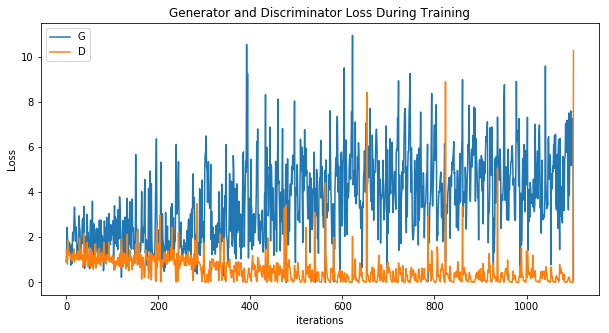

In [37]:
# Plot losses

#Labels of Cifar-10 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
# generation to image
G.eval()

# put here the desired label you want to be seen
desired_label = 0

y_rand = torch.full((batch_size, 1), desired_label).type(torch.LongTensor).squeeze()
y_label = onehot[y_rand]
#y_label = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10,1), 1).view(10, 10, 1, 1)
z = Variable(z.cuda())
y_label = Variable(y_label.cuda())


# Generate images using fixed noise and specific labels. For example "generate fake landscape images"
with torch.no_grad():
    fake_images = G(fixed_noise,y_label).detach().cpu()


    

# Plot figures of specific labels    
    
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE)[:64], padding=5,pad_value = 1, normalize=True).cpu(),(1,2,0)))


# Plot each image separately.

#print(fake_images[0][0].shape)
#for i in range(20):
 #   plt.imshow(fake_images[i][0])
  #  plt.show()

In [0]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [0]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_dc.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_dc.pth.tar')